![](https://raw.githubusercontent.com/georgsmeinung/tpi-simulacion/refs/heads/main/austral-ingenieria.png)

# Maestría en Ciencia de Datos 2024/2025

## Simulación y Optimización en Ciencia de Datos 
## Trabajo Práctico Integral

Profesores:

- DEL ROSSO, Rodrigo
- NUSKE, Ezequiel

Integrantes:

-   CANCELAS, Martín
-   FILIPUZZI, Juan Manuel
-	NICOLAU, Jorge


### Introducción

Este Trabajo Práctico (TP) integra los contenidos vistos en las clases

- **Unidad I** – Generación de números pseudoaleatorios y Monte Carlo
- **Unidad II** – Bayes, cadenas de Markov y Metropolis–Hastings
- **Unidad III** – Simulación de eventos discretos (SED)
- **Unidad IV** – Procesos continuos (NHPP, CTMC, SDE)
- **Unidad V** – Reacciones químicas estocásticas: Gillespie SSA y Next Reaction Method
 
El objetivo es que el alumno implemente técnicas de simulación, compare métodos, valide sus resultados y presente visualizaciones claras.

### Sobre el código base
El código base propuesto en el enunciado en R se ha transformado a Python y se encuentra en el anexo al final del trabajo.

### Configuración

Para el presente trabajo se utilizan los siguientes parámetros globales y semilla

In [1]:
# CONFIGURACIÓN
# Parámetros (LCG estándar de C++ minstd_rand)
lgc_a, lgc_c, lgc_m = 48271, 0, 2**31 - 1
# Semilla
rnd_seed = 2371

### Parte 1 - Generación de Números Pseudoaleatorios y Monte Carlo

#### Implementación de un Generador Congruencial Lineal (LCG)
La implementación de un Generador Congruencial Lineal (LCG) se fundamenta en un algoritmo iterativo y determinista regido por la relación de recurrencia 

$$X_{n+1} = (aX_n + c) \mod m$$

mediante la cual se produce una secuencia de números pseudoaleatorios a partir de un valor inicial denominado semilla ($X_0$). El proceso requiere la definición de tres constantes enteras —el multiplicador ($a$), el incremento ($c$) y el módulo ($m$)— y opera calculando el siguiente valor de la serie al multiplicar el estado actual por $a$, sumar $c$ y obtener el residuo de la división por $m$, resultando en una sucesión periódica que, si bien carece de aleatoriedad verdadera, es computacionalmente eficiente y totalmente reproducible si se mantienen los mismos parámetros iniciales.

Al usar operaciones aritméticas básicas, es extremadamente rápido computacionalmente. Como hay un número finito de resultados posibles (de $0$ a $m-1$), la secuencia eventualmente se repetirá. A esto se le llama el "periodo". Por otra parte si se usa la misma semilla ($X_0$), se obtendrá exactamente la misma secuencia de números. Esto es útil para "debugging" o reproducir simulaciones científicas, pero malo para la seguridad. No es seguro criptográficamente: No se debe usar para contraseñas o claves de seguridad, ya que es relativamente fácil predecir los siguientes números analizando la secuencia previa.

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Implementación del LCG
def lcg_generator(seed, a, c, m, n):
    numbers = []
    x = seed
    for _ in range(n):
        x = (a * x + c) % m
        # Normalizar a [0, 1]
        numbers.append(x / m) 

    return numbers

Para evaluar la calidad de los números pseudoaleatorios generados por uel LCG, es necesario verificar dos propiedades fundamentales: Uniformidad e Independencia. A continuación, se detalla la lógica de implementación y el código en Python para las tres herramientas solicitadas.

#### Histograma
El histograma visualiza la distribución de frecuencia de los números generados. Para un buen generador, esperamos una distribución uniforme (plana), lo que significa que cada intervalo del rango tiene aproximadamente la misma probabilidad de contener un número.

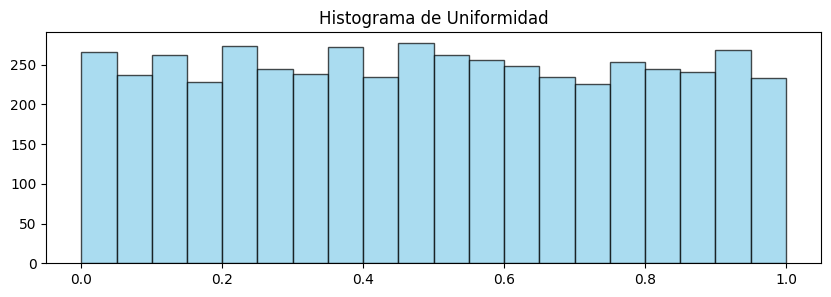

In [3]:
datos = lcg_generator(seed=rnd_seed, a=lgc_a, c=lgc_c, m=lgc_m, n=5000)

# Histograma
plt.figure(figsize=(10, 3))
plt.hist(datos, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histograma de Uniformidad')
plt.show()

La presencia de alturas similares en todas las barras ("bins") del histograma indica que el Generador Congruencial Lineal (LCG) está cumpliendo satisfactoriamente con la propiedad de uniformidad, lo que significa que cada sub-intervalo del rango tiene una probabilidad casi idéntica de contener un número generado. Esta distribución "plana" o rectangular sugiere que el algoritmo recorre el espacio muestral sin sesgos evidentes ni favoritismos hacia ciertos valores; sin embargo, es crucial notar que estas variaciones leves deben ser producto del azar natural (pequeñas fluctuaciones son esperadas y saludables), y aunque este patrón valida la equiprobabilidad, por sí solo no garantiza la independencia de los datos (ausencia de patrones secuenciales), por lo que un histograma visualmente equilibrado es una condición necesaria, pero no suficiente, para aprobar un generador.

#### Runs Test (Prueba de Rachas/Corridas)

Esta prueba verifica la independencia analizando la secuencia de oscilaciones. Una "racha" es una secuencia ininterrumpida de números crecientes o decrecientes.

Para la lógica de Implementación (con Corridas Arriba/Abajo) se toma la secuencia $u_1, u_2, \dots, u_n$. Se crea una nueva secuencia binaria basada en si el valor actual es mayor o menor que el anterior ($+$ si $u_i < u_{i+1}$, $-$ si $u_i > u_{i+1}$). Luego se cuenta el número total de rachas (cambios de $+$ a $-$ o viceversa). Se calcual el estadístico Z comparando el número de rachas obtenido con el esperado teóricamente usando la aproximación normal para muestras grandes ($N > 20$).

$$\mu_R = \frac{2N - 1}{3}$$
$$\sigma_R^2 = \frac{16N - 29}{90}$$
$$Z = \frac{R - \mu_R}{\sigma_R}$$ 

Si el valor absoluto de $Z$ ($|Z|$) es mayor que el valor crítico (ej. $1.96$ para un 95% de confianza), se rechaza la hipótesis de independencia.

In [4]:
# Runs Test
runs = 1 # Empieza la primera racha
for i in range(len(datos) - 1):
    # Si la dirección cambia respecto al anterior, es nueva racha
    if i > 0:
        prev_diff = datos[i] - datos[i-1]
        curr_diff = datos[i+1] - datos[i]
        # Si el producto es negativo, hubo cambio de signo (dirección)
        if prev_diff * curr_diff < 0:
            runs += 1

expected_runs = (2 * len(datos) - 1) / 3
print(f"Rachas observadas: {runs}")
print(f"Rachas esperadas: {expected_runs:.2f}")

Rachas observadas: 3325
Rachas esperadas: 3333.00


La cercanía entre las rachas observadas y las esperadas revela una discrepancia numérica mínima, lo cual sugiere que el Generador Congruencial Lineal (LCG) cumple satisfactoriamente con la propiedad de independencia estadística. Este resultado indica que la secuencia de números fluctúa (asciende y desciende) con una frecuencia consistente con el azar puro, descartando la presencia de patrones de dependencia serial; al no existir una desviación significativa (la diferencia es muy pequeña considerando el tamaño de la muestra), el valor estadístico $Z$ resultante sería muy cercano a cero, lo que impide rechazar la hipótesis nula y permite concluir que los datos no están correlacionados entre sí, validando el motor como un generador robusto en términos de oscilación.

#### Gráfico de Triples (Spectral Test Visual)

Esta es una visualización en 3D para detectar correlaciones seriales. Los generadores LCG malos tienden a concentrar los puntos en planos discretos en lugar de llenar el espacio uniformemente (fenómeno conocido como planos de Marsaglia). 

El gráfico de triples opera bajo la lógica de visualización del espacio de fases para detectar correlaciones seriales de largo alcance, mapeando tríadas consecutivas de la secuencia generada $(u_n, u_{n+1}, u_{n+2})$ como coordenadas espaciales $(x, y, z)$ en un cubo tridimensional. La premisa fundamental es que, si los números fueran verdaderamente independientes, los puntos deberían llenar el volumen de manera caótica y uniforme como una "nube de polvo"; sin embargo, debido a la naturaleza lineal de la fórmula $X_{n+1} = (aX_n + c)$, los LCGs deficientes exhiben una estructura cristalina donde los puntos se alinean rígidamente en un número finito de planos paralelos (fenómeno conocido como planos de Marsaglia), revelando visualmente que la aleatoriedad es solo aparente y que existen dependencias matemáticas estrictas entre valores sucesivos.

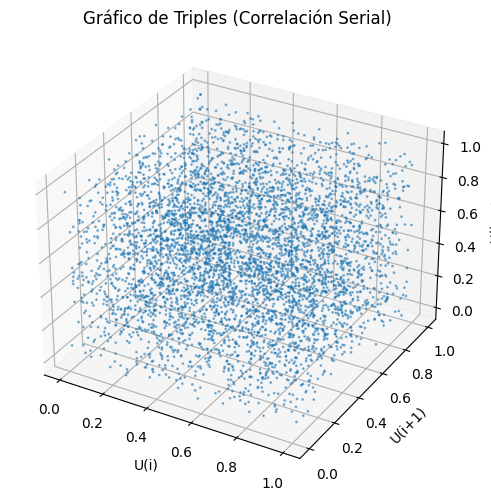

In [5]:
# Esto estira el lienzo hacia la derecha.
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

# Crear tripletas
x_vals = datos[:-2]
y_vals = datos[1:-1]
z_vals = datos[2:]

ax.scatter(x_vals, y_vals, z_vals, s=1, alpha=0.5)

ax.set_title('Gráfico de Triples (Correlación Serial)')
ax.set_xlabel('U(i)')
ax.set_ylabel('U(i+1)')
ax.set_zlabel('U(i+2)')
plt.subplots_adjust(right=0.75, left=0.1, bottom=0.1, top=0.9)

plt.show()


La observación de una nube de puntos dispersa y volumétrica que llena el cubo de manera homogénea se interpreta como una validación exitosa de la calidad espectral del generador, indicando que la correlación serial entre ternas consecutivas $(u_n, u_{n+1}, u_{n+2})$ es despreciable o inexistente para fines prácticos. Visualmente, esto contrasta con los generadores deficientes que agrupan los puntos en "rebanadas" o planos paralelos separados; por el contrario, una distribución uniforme implica que el algoritmo posee un periodo lo suficientemente largo y unos parámetros adecuados para "romper" la estructura reticular visible, garantizando que no existen dependencias geométricas fuertes y haciendo al generador apto para simulaciones Monte Carlo multidimensionales.

#### Estimación de $\pi$ por Monte Carlo

La estimación del valor de $\pi$ mediante el método de Monte Carlo utiliza el Generador Congruencial Lineal (LCG) para producir pares de coordenadas $(x, y)$ uniformemente distribuidas en el intervalo $[0, 1)$, simulando el lanzamiento aleatorio de puntos sobre un cuadrado unitario que contiene un cuarto de círculo inscrito. El procedimiento se fundamenta en la geometría probabilística: dado que el área del cuarto de círculo es $\pi/4$ y el área del cuadrado es $1$, la probabilidad de que un punto caiga dentro del círculo es exactamente $\pi/4$; por consiguiente, al verificar cuántos puntos cumplen la condición $x^2 + y^2 \le 1$ y dividir esa cantidad por el número total de puntos generados, se obtiene una proporción que, multiplicada por $4$, aproxima el valor de $\pi$, sirviendo esto a su vez como una prueba funcional de la calidad del LCG, ya que un generador sesgado o correlacionado (como el que forma líneas en el gráfico de triples) arrojará un valor de $\pi$ incorrecto al no cubrir el área uniformemente.

Lógica de Implementación
1. Generación de Pares: Se utiliza el LCG para obtener dos números consecutivos normalizados ($u_i, u_{i+1}$) que actúan como coordenadas $x$ e $y$.
2. Condición Geométrica: Se calcula la distancia al origen ($d = x^2 + y^2$).
3. Conteo: Si $d \le 1$, el punto está "dentro" del círculo (Acierto).
4. Cálculo Final: $\pi \approx 4 \times \frac{\text{Aciertos}}{\text{Total de Puntos}}$.

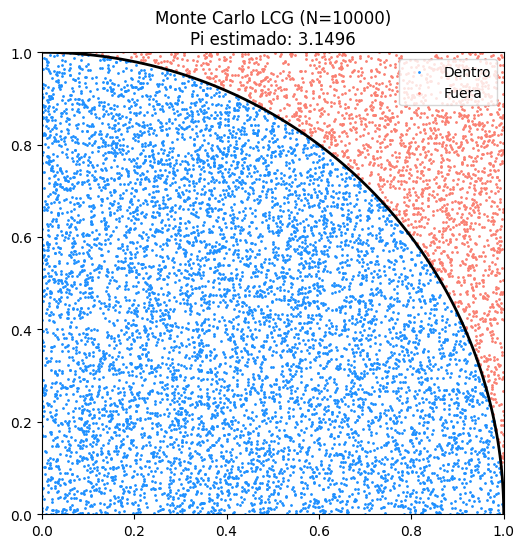

Puntos procesados: 10000
Valor estimado de Pi: 3.1496
Diferencia real: 0.008007


In [6]:
# Función Monte Carlo con Gráfico y Retorno de Valor
def estimar_y_graficar_pi(n_puntos):   
    # Se generan los números necesarios (2 por punto)
    s, a, c, m = rnd_seed, lgc_a, lgc_c, lgc_m
    lista_completa = lcg_generator(s, a, c, m , n_puntos * 2)
    iterador_numeros = iter(lista_completa)
    
    # Listas para guardar coordenadas (visualización)
    inside_x, inside_y = [], []
    outside_x, outside_y = [], []
    
    dentro_count = 0
    
    for _ in range(n_puntos):
        # Extraer par (x, y)
        x = next(iterador_numeros)
        y = next(iterador_numeros)
        
        # Clasificar
        if x**2 + y**2 <= 1.0:
            dentro_count += 1
            inside_x.append(x)
            inside_y.append(y)
        else:
            outside_x.append(x)
            outside_y.append(y)
            
    # Estimación del valor
    pi_estimado = 4 * (dentro_count / n_puntos)

    # GRAFICO CONTEO
    plt.figure(figsize=(6, 6))
    
    # Puntos dentro (Azul) y fuera (Rojo)
    plt.scatter(inside_x, inside_y, color='dodgerblue', s=1, label='Dentro')
    plt.scatter(outside_x, outside_y, color='salmon', s=1, label='Fuera')
    
    # Arco del círculo (estético)
    t = np.linspace(0, np.pi/2, 100)
    plt.plot(np.cos(t), np.sin(t), 'k-', lw=2)
    
    plt.xlim(0, 1); plt.ylim(0, 1)
    plt.gca().set_aspect('equal')
    plt.title(f"Monte Carlo LCG (N={n_puntos})\nPi estimado: {pi_estimado}")
    plt.legend(loc="upper right")
    plt.show()
    
    # --- RETORNO ESTIMACIÓN ---
    return pi_estimado

# Ejecución con diez mil puntos
n = 10000
pi_val = estimar_y_graficar_pi(n)

print(f"Puntos procesados: {n}")
print(f"Valor estimado de Pi: {pi_val}")
print(f"Diferencia real: {abs(pi_val - 3.14159265):.6f}")

### Parte 2 - Metropolis–Hastings y Bayesian Inference

La relación entre el algoritmo de Metropolis-Hastings y la inferencia bayesiana es fundamentalmente instrumental, donde el primero actúa como la solución computacional para los desafíos analíticos planteados por el segundo. La inferencia bayesiana busca estimar la distribución posterior de parámetros desconocidos, denotada como $P(\theta | D)$, mediante la aplicación del Teorema de Bayes. No obstante, este proceso conlleva frecuentemente el cálculo de una constante de normalización —la evidencia marginal— que implica resolver integrales multidimensionales analíticamente intratables, lo cual impide la obtención directa de la distribución posterior en modelos complejos.

El algoritmo de Metropolis-Hastings, perteneciente a la familia de métodos de Monte Carlo vía Cadenas de Markov (MCMC), se distingue por su capacidad para generar muestras de una distribución de probabilidad objetivo sin necesidad de conocer su constante de normalización. El algoritmo opera construyendo una cadena de Markov que converge asintóticamente a la distribución deseada, requiriendo únicamente una función que sea proporcional a dicha densidad objetivo para evaluar los ratios de aceptación de las muestras propuestas.

En consecuencia, la conexión crítica reside en que la distribución posterior no normalizada en la estadística bayesiana es proporcional al producto de la función de verosimilitud y la distribución a priori ($Likelihood \times Prior$). Dado que Metropolis-Hastings puede operar bajo condiciones de proporcionalidad, este algoritmo permite muestrear la distribución posterior y realizar inferencias sobre los parámetros sin tener que calcular la integral de la evidencia marginal, haciendo viable el análisis bayesiano en escenarios de alta dimensionalidad donde las soluciones cerradas son imposibles.

#### Posterior beta analítica
Sea una moneda con 10 lanzamientos y 7 caras, para obtener una posterior $\text{Beta}(8,4)$ a partir de 7 caras ($k=7$) y 3 cruces ($n-k=3$), debemos asumir un prior Uniforme o $\text{Beta}(1,1)$. En la inferencia Bayesiana, demode que si se usa un Prior Beta y un Likelihood Binomial, el Posterior siempre es otra Beta:

- Likelihood (Verosimilitud): $P(X|\theta) \propto \theta^7 (1-\theta)^3$
- Prior (A priori): $P(\theta) \sim \text{Beta}(1,1) \propto 1$
- Posterior (A posteriori): $P(\theta|X) \propto \theta^{7+1-1} (1-\theta)^{3+1-1} = \theta^7 (1-\theta)^3 \rightarrow \text{Beta}(8,4)$

En términos de Python:

In [7]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import arviz as az

# Funciones del modelo
def log_prior(theta):
    """
    Prior Beta(1,1) (Uniforme en [0, 1]).
    Retorna 0 si está en rango (log(1)), -inf si no.
    """
    if 0 <= theta <= 1:
        return 0.0
    return -np.inf

def log_likelihood(theta, heads, trials):
    """
    Log-Likelihood Binomial.
    """
    if theta < 0 or theta > 1:
        return -np.inf
    # Proporcional a theta^k * (1-theta)^(n-k)
    return (heads * np.log(theta)) + ((trials - heads) * np.log(1 - theta))

def log_posterior(theta, heads, trials):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, heads, trials)

Como el objetivo es obtener exactamente $\text{Beta}(8,4)$ con 7 caras y 3 cruces, implícitamente se está asumiendo que no se aporta información previa (el 1 inicial de la Beta actúa como un "neutro" o punto de partida cero en términos de influencia).

In [8]:
# Configuración del Problema
np.random.seed(rnd_seed)

# Datos observados: 10 lanzamientos, 7 caras
n_trials = 10
n_heads = 7

# Parámetros del algoritmo MCMC
n_chains = 4        # Solicitado explícitamente para R-hat
n_samples = 5000    # Muestras por cadena
burnin = 1000       # Periodo de calentamiento (burn-in)
step_size = 0.1     # Desviación estándar de la propuesta (Proposal width)

# Algoritmo Metropolis-Hastings

def metropolis_hastings(n_samples, n_chains, heads, trials, step_size):
    chains = []
    
    print(f"Iniciando muestreo con {n_chains} cadenas...")
    
    for chain_idx in range(n_chains):
        samples = []
        # Punto de inicio aleatorio para cada cadena
        current_theta = np.random.uniform(0.1, 0.9)
        current_log_post = log_posterior(current_theta, heads, trials)
        
        for i in range(n_samples + burnin):
            # 1. Propuesta: Random Walk (Normal centrada en theta actual)
            proposal = np.random.normal(current_theta, step_size)
            
            # 2. Calcular Log-Posterior de la propuesta
            proposal_log_post = log_posterior(proposal, heads, trials)
            
            # 3. Ratio de Aceptación (en escala logarítmica para estabilidad)
            # r = p(new)/p(old). log(r) = log(p(new)) - log(p(old))
            log_ratio = proposal_log_post - current_log_post
            
            # 4. Decisión de aceptación
            if np.log(np.random.rand()) < log_ratio:
                current_theta = proposal
                current_log_post = proposal_log_post
            
            # Guardar solo después del burn-in
            if i >= burnin:
                samples.append(current_theta)
        
        chains.append(samples)
        print(f"Cadena {chain_idx + 1} completada.")
        
    return np.array(chains)

# Ejecutar el sampler
samples, chains, heads, trials = n_samples, n_chains, n_heads, n_trials
chains = metropolis_hastings(samples, chains, heads, trials, step_size)

# Convertir a objeto InferenceData de Arviz para facilitar diagnósticos
idata = az.from_dict(posterior={"theta": chains})

Iniciando muestreo con 4 cadenas...
Cadena 1 completada.
Cadena 2 completada.
Cadena 3 completada.
Cadena 4 completada.


#### Diagnósticos Obligtatorios

#### Traceplot
El Traceplot permite visualizar la evolución temporal de las cadenas de Markov, facilitando la verificación inmediata de la convergencia asintótica y la calidad del muestreo. A través de este gráfico se evalúa si el algoritmo ha alcanzado la estacionariedad (oscilando alrededor de un valor estable sin tendencias) y si existe una mezcla adecuada del espacio de parámetros (exploración eficiente), lo cual es indispensable para validar que las muestras obtenidas son representativas de la distribución posterior objetivo y descartar problemas como una alta autocorrelación o una configuración errónea del tamaño de paso.

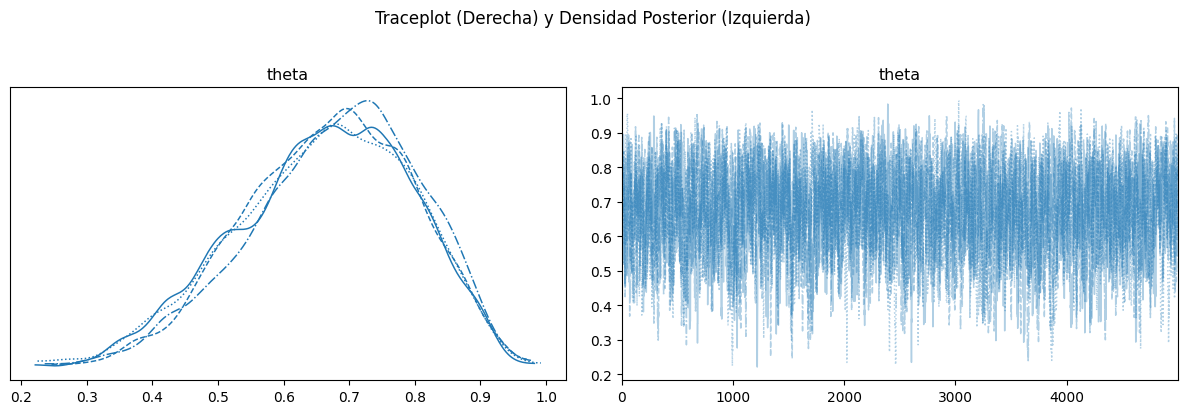

In [9]:
# Traceplot y Densidad (Histograma implícito en kde)
# Arviz genera automáticamente 
# Traceplot a la derecha y la densidad a la izquierda
az.plot_trace(idata)
graph_title = "Traceplot (Derecha) y Densidad Posterior (Izquierda)"
plt.suptitle(graph_title, y=2.05, fontsize=12)
plt.subplots_adjust(top=.75)
plt.tight_layout(rect=[0, 0, 1, 2])
plt.show()

El gráfico confirma la convergencia exitosa y robusta del algoritmo Metropolis-Hastings, validando la calidad de la inferencia realizada. En el panel derecho (Traceplot), se observa una oscilación densa y constante alrededor de un eje central sin tendencias visibles —patrón "oruga peluda"—, lo cual demuestra que las cuatro cadenas han alcanzado la estacionariedad y exploran el espacio de parámetros con una mezcla eficiente y homogénea. Corroborando esto, el panel izquierdo (Densidad Posterior) exhibe una superposición casi perfecta de las distribuciones estimadas por cada cadena, indicando consistencia interna (bajo R-hat) y revelando una moda centrada aproximadamente en 0.7, valor que coincide con el máximo teórico esperado para la distribución Beta(8,4).

#### Autocorrelación

El análisis de la autocorrelación permite cuantificar la dependencia serial inherente entre las muestras generadas por la cadena de Markov, dado que los algoritmos MCMC producen, por definición, observaciones correlacionadas en lugar de independientes. Este diagnóstico es crítico para evaluar la eficiencia del muestreo (mixing), ya que una persistencia alta de la correlación a través de múltiples retardos (lags) indica una exploración lenta del espacio de parámetros y reduce el tamaño de muestra efectivo (ESS), lo que alertaría sobre la necesidad de incrementar el número de iteraciones o ajustar el tamaño de paso para garantizar que la inferencia estadística sobre la posterior sea fiable y precisa.

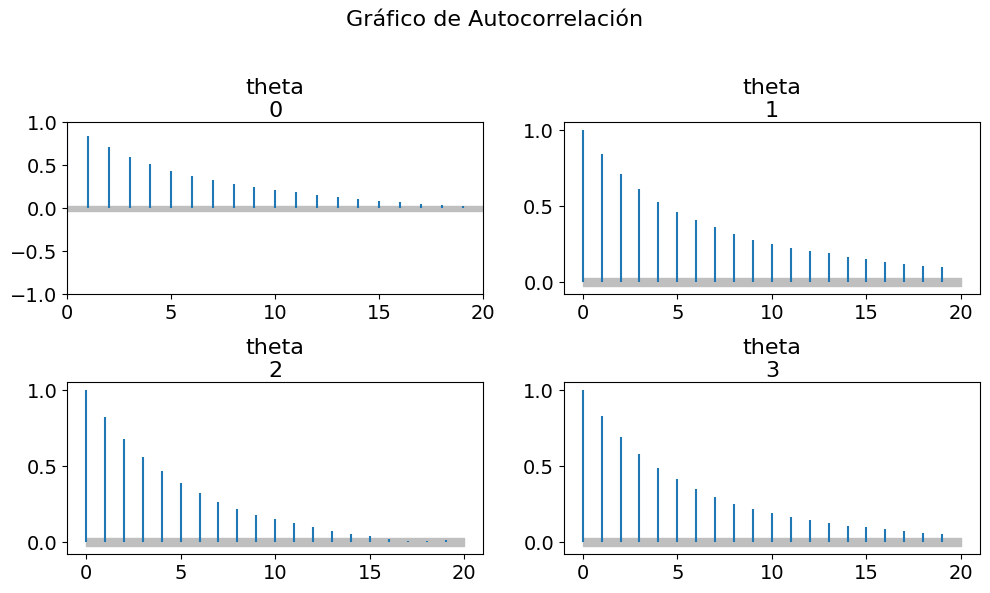

In [10]:
# Autocorrelación
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
az.plot_autocorr(idata, max_lag=20, ax=axes)
plt.suptitle("Gráfico de Autocorrelación", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Los gráficos de autocorrelación revelan una persistente dependencia serial entre las muestras sucesivas, evidenciada por un decaimiento lento de las barras que mantienen valores significativos incluso después de 15 a 20 retardos (*lags*). Este comportamiento, consistente en las cuatro cadenas analizadas, indica una eficiencia de mezcla (*mixing*) moderada y una exploración del espacio de parámetros con cierta "viscosidad", lo cual reduce el Tamaño de Muestra Efectivo (ESS) e implica que, para fines de inferencia estadística robusta, la cantidad de información independiente real es considerablemente menor al número total de iteraciones computadas.

#### Histograma vs Analítica Beta(8,4)

La superposición del histograma de frecuencias empíricas frente a la curva analítica de la distribución Beta es una prueba definitiva de validación, aprovechando que el modelo Beta-Binomial posee una solución cerrada conocida que sirve como "verdad fundamental" (*ground truth*). Este diagnóstico visual permite confirmar rigurosamente que el algoritmo Metropolis-Hastings está muestreando fielmente de la distribución objetivo y no de una aproximación errónea, verificando así que la lógica computacional, la función de verosimilitud y el mecanismo de aceptación/rechazo han sido implementados con exactitud matemática y que el muestreador recupera la geometría correcta de la posterior sin sesgos.

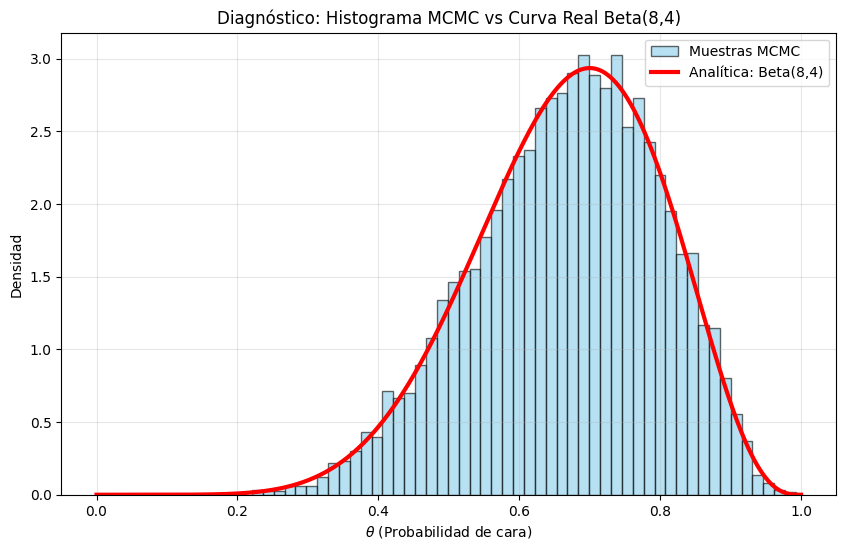

In [11]:
# Histograma vs Analítica Beta(8,4)
plt.figure(figsize=(10, 6))

# Aplanar las cadenas para el histograma
flat_samples = chains.flatten()

# Histograma de muestras MCMC
plt.hist(
    flat_samples,
    bins=50,
    density=True,
    alpha=0.6,
    color='skyblue',
    label='Muestras MCMC',
    edgecolor='black'
)

# Curva Analítica Real Beta(8,4)
x = np.linspace(0, 1, 1000)

# Posterior analítica: 7 caras + 1, 3 cruces + 1
pdf_true = stats.beta.pdf(x, 8, 4)

plt.plot(x, pdf_true, 'r-', lw=3, label='Analítica: Beta(8,4)')

plt.title("Diagnóstico: Histograma MCMC vs Curva Real Beta(8,4)")
plt.xlabel(r"$\theta$ (Probabilidad de cara)")
plt.ylabel("Densidad")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

El gráfico evidencia una correspondencia altamente satisfactoria entre la distribución empírica generada por el algoritmo (histograma azul) y la solución analítica teórica (curva roja), demostrando la exactitud de la implementación. La alineación precisa de las frecuencias de las barras con el perfil de la función de densidad Beta(8,4) confirma que el muestreador ha logrado capturar fielmente la estructura probabilística de la posterior, reproduciendo correctamente tanto la ubicación de la moda en torno a 0.7 como la dispersión asociada, lo cual valida que las muestras obtenidas son estadísticamente representativas de la distribución objetivo y legitima el uso de la simulación para la inferencia paramétrica.

#### R-hat con 4 cadenas y ESS (Effective Sample Size)

Las métricas R-hat y ESS (Tamaño de Muestra Efectivo) proporcionan una validación cuantitativa y objetiva de la fiabilidad y precisión de la simulación, superando las limitaciones de la inspección visual. El estadístico R-hat resulta indispensable al utilizar múltiples cadenas para verificar matemáticamente la convergencia global, asegurando a través de la comparación de varianzas que el algoritmo no ha quedado atrapado en óptimos locales; simultáneamente, el ESS es crítico para cuantificar el volumen real de información independiente generada descontando la autocorrelación, garantizando así que la estimación de la posterior posea un error estándar de Monte Carlo lo suficientemente reducido para ser estadísticamente válida.

In [12]:
# R-hat y ESS (Effective Sample Size)
summary = az.summary(idata, kind="diagnostics")

print("DIAGNÓSTICOS NUMÉRICOS")
print("-" * 60)
print(summary)
print("-" * 60)

# Verificación explicita de valores
r_hat_val = summary.loc['theta', 'r_hat']
ess_val = summary.loc['theta', 'ess_bulk']

print(f"R-hat obtenido (Ideal < 1.01): {r_hat_val:.4f}")
print(f"ESS (Effective Sample Size): {ess_val:.1f}")

DIAGNÓSTICOS NUMÉRICOS
------------------------------------------------------------
       mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
theta      0.003    0.002    1691.0    1971.0    1.0
------------------------------------------------------------
R-hat obtenido (Ideal < 1.01): 1.0000
ESS (Effective Sample Size): 1691.0


Los diagnósticos numéricos validan la robustez técnica de la simulación, destacando un estadístico R-hat de 1.0 que confirma la convergencia perfecta de las cadenas y su indistinguibilidad estadística. Por su parte, el Tamaño de Muestra Efectivo (ESS) de 1691.0, aunque inferior al total de iteraciones debido a la correlación serial, resulta suficiente para garantizar estimaciones estables de la tendencia central, lo cual, sumado a un error estándar de Monte Carlo (mcse) marginal de 0.003, asegura que la precisión de la inferencia sobre la posterior es elevada y que el error introducido por el método de muestreo es despreciable.

### Parte 3 - Simulación de Eventos Discretos (M/M/1 o M/M/c)

Para implementar esta simulación, el motor central debe basarse en una **Lista de Eventos Futuros (LEF)** ordenada cronológicamente y una variable de reloj ($T_{now}$). El tiempo no avanza de forma continua, sino que "salta" discretamente al instante del evento más próximo en la lista. Inicialmente, se genera la primera llegada aleatoria (usando la tasa $\lambda=10$) y se inserta en la LEF; el ciclo de simulación consiste en extraer repetidamente el evento de menor tiempo de la lista, actualizar el reloj a ese instante y ejecutar la lógica de cambio de estado correspondiente hasta que $T_{now}$ supere las 8 horas.

La lógica de estado maneja dos eventos principales: Llegada y Salida. Al procesar una Llegada, se programa inmediatamente la siguiente llegada futura y se evalúan los servidores: si hay alguno libre (de los $c$ disponibles), se ocupa y se calcula una duración de servicio (con tasa $\mu=4$) para insertar un evento de Salida en la LEF; si todos están ocupados, se incrementa el contador de la cola. Por otro lado, al procesar una Salida, se libera el servidor, pero si la cola no está vacía, se decrementa inmediatamente para ingresar al siguiente cliente al servicio, generando su respectivo evento de finalización futuro.

#### Simulación 8 horas de un sistemas de colas

Esta es una implementaciónen Python de una simulación de eventos discretos (DES) utilizando una Lista de Eventos Futuros (LEF) implementada con una cola de prioridad (heapq). El código está diseñado para soportar tanto M/M/1 (1 servidor) como M/M/c (múltiples servidores), pero además tenemos estos parámetros:

- $\lambda$ (Tasa de llegadas): 10 clientes/hora.
- $\mu$ (Tasa de servicio): 4 clientes/hora.
- $c$ (Servidores): Variable.

Es importante resaltar que si usamos $c=1$ (M/M/1), el sistema será inestable porque la tasa de llegada (10) es mayor que la capacidad de servicio (4). La cola crecerá infinitamente. Para un sistema estable, necesitamos $c \ge 3$ (capacidad 12 > 10). Por esto se ha configurado el código por defecto con NUM_SERVIDORES = 3, pero puede cambiarse a 1 para observar cómo se satura.

In [13]:
import random
import heapq
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from IPython.display import Image, display

class SimulacionMMC_Log:
    def __init__(self, tiempo_max, tasa_llegada,
                 tasa_servicio, n_servidores):
        # Ajustamos los parámetros iniciales
        self.tiempo_max = tiempo_max
        self.tasa_llegada = tasa_llegada
        self.tasa_servicio = tasa_servicio
        self.n_servidores = n_servidores
        
        # Estado del sistema
        self.reloj = 0.0
        self.num_en_cola = 0
        self.servidores_ocupados = 0
        self.lef = []  # Lista de Eventos Futuros
        
        # Estadísticas y Acumuladores
        self.total_llegadas = 0
        self.total_atendidos = 0
        self.area_cola = 0.0      # Para calcular Lq
        self.area_ocupados = 0.0  # Para calcular utilización
        self.tiempo_ultimo_evento = 0.0
        
        # Historial para Animación
        self.historia = [(0.0, 0, 0)]

    def actualizar_estadisticas(self, tiempo_actual):
        """Calcula áreas bajo la curva antes de cambiar estado."""
        delta_t = tiempo_actual - self.tiempo_ultimo_evento
        self.area_cola += self.num_en_cola * delta_t
        self.area_ocupados += self.servidores_ocupados * delta_t
        self.tiempo_ultimo_evento = tiempo_actual

    def correr(self):
        # Programar primera llegada
        t_llegada = random.expovariate(self.tasa_llegada)
        heapq.heappush(self.lef, (t_llegada, 0))  # 0 = LLEGADA
        
        msg = (f"Iniciando Simulación M/M/{self.n_servidores} "
               f"por {self.tiempo_max} horas")
        print(msg)
        
        while self.reloj < self.tiempo_max and self.lef:
            tiempo_evento, tipo_evento = heapq.heappop(self.lef)
            
            if tiempo_evento > self.tiempo_max:
                # Actualizar hasta tiempo final exacto
                self.actualizar_estadisticas(self.tiempo_max)
                self.reloj = self.tiempo_max
                break
            
            # 1. Actualizar estadísticas
            self.actualizar_estadisticas(tiempo_evento)
            
            # 2. Avanzar reloj
            self.reloj = tiempo_evento
            
            # 3. Procesar evento
            if tipo_evento == 0:  # LLEGADA
                self.procesar_llegada()
            else:  # SALIDA
                self.procesar_salida()
            
            # 4. Guardar foto para la animación
            self.historia.append((
                self.reloj,
                self.num_en_cola,
                self.servidores_ocupados
            ))

        # AL FINALIZAR EL BUCLE: MOSTRAR RESULTADOS
        self.reporte_final()

    def procesar_llegada(self):
        self.total_llegadas += 1
        prox = self.reloj + random.expovariate(self.tasa_llegada)
        heapq.heappush(self.lef, (prox, 0))
        
        if self.servidores_ocupados < self.n_servidores:
            self.servidores_ocupados += 1
            t_salida = self.reloj + random.expovariate(
                self.tasa_servicio
            )
            heapq.heappush(self.lef, (t_salida, 1))
        else:
            self.num_en_cola += 1

    def procesar_salida(self):
        self.total_atendidos += 1
        if self.num_en_cola > 0:
            self.num_en_cola -= 1
            t_salida = self.reloj + random.expovariate(
                self.tasa_servicio
            )
            heapq.heappush(self.lef, (t_salida, 1))
        else:
            self.servidores_ocupados -= 1

    def reporte_final(self):
        print("\n" + "="*40)
        print("      RESULTADOS DE LA SIMULACIÓN")
        print("="*40)
        print(f"Tiempo simulado: {self.reloj:.2f} horas")
        print(f"Total llegadas:  {self.total_llegadas}")
        print(f"Total atendidos: {self.total_atendidos}")
        print("-" * 40)
        
        # Cálculos de promedios
        lq = self.area_cola / self.reloj
        
        prom_ocupados = self.area_ocupados / self.reloj
        utilizacion = prom_ocupados / self.n_servidores
        
        # Wq usando fórmula de Little
        lambda_real = self.total_llegadas / self.reloj
        wq = lq / lambda_real if lambda_real > 0 else 0
        
        print(f"Longitud prom cola (Lq): {lq:.4f} clientes")
        print(f"Tiempo prom cola (Wq): {wq*60:.2f} minutos")
        print(f"Servidores ocupados (prom): {prom_ocupados:.2f}")
        print(f"Utilización (Rho): {utilizacion*100:.2f}%")
        print("="*40 + "\n")

    def graficar_historial(self):
        """Gráficos estáticos de evolución de cola y servidores."""
        # 1. Desempaquetar datos
        tiempos = [d[0] for d in self.historia]
        n_cola = [d[1] for d in self.historia]
        n_ocupados = [d[2] for d in self.historia]

        # 2. Configurar figura (2 subplots)
        fig, (ax1, ax2) = plt.subplots(
            2, 1, figsize=(10, 8), sharex=True
        )

        # Gráfico 1: Evolución de la Cola
        ax1.step(tiempos, n_cola, where='post',
                 color='tab:blue', linewidth=1.5)
        ax1.fill_between(tiempos, n_cola, step='post',
                         alpha=0.2, color='tab:blue')
        ax1.set_ylabel('Clientes en Cola')
        ax1.set_title(
            f'Evolución Cola (M/M/{self.n_servidores})'
        )
        ax1.grid(True, linestyle='--', alpha=0.6)

        # Gráfico 2: Uso de Servidores
        ax2.step(tiempos, n_ocupados, where='post',
                 color='tab:orange', linewidth=1.5)
        ax2.fill_between(tiempos, n_ocupados, step='post',
                         alpha=0.2, color='tab:orange')
        ax2.set_ylabel('Servidores Ocupados')
        ax2.set_xlabel('Tiempo de Simulación (horas)')
        ax2.set_title('Ocupación de Servidores')
        
        # Línea de capacidad máxima
        ax2.axhline(y=self.n_servidores, color='red',
                    linestyle=':', label='Capacidad Max')
        ax2.set_ylim(0, self.n_servidores + 0.5)
        ax2.legend()
        ax2.grid(True, linestyle='--', alpha=0.6)

        plt.tight_layout()
        plt.show()

A continuación se utiliza la clase de Simulación M/M/c implementada. Si `n_servidores=1` la cola crece infinitamente, esto ese produce un cuello de botella

In [14]:
# Configurar la simulación (8 horas, lambda=10, mu=4, c=3)
mi_simulacion = SimulacionMMC_Log(
    tiempo_max=8.0, 
    tasa_llegada=10.0, 
    tasa_servicio=4.0, 
    n_servidores=3
)

# Correr la simulación matemática
mi_simulacion.correr()

Iniciando Simulación M/M/3 por 8.0 horas

      RESULTADOS DE LA SIMULACIÓN
Tiempo simulado: 8.00 horas
Total llegadas:  80
Total atendidos: 79
----------------------------------------
Longitud prom cola (Lq): 2.0640 clientes
Tiempo prom cola (Wq): 12.38 minutos
Servidores ocupados (prom): 2.43
Utilización (Rho): 81.12%



Para visualizar los resultados de la simulación de eventos discretos se usan gráficos de paso (step plots) dad que el estado del sistema (número en cola en espera o servidores ocupados) permanece constante entre eventos y va cambiando con cada arribo.

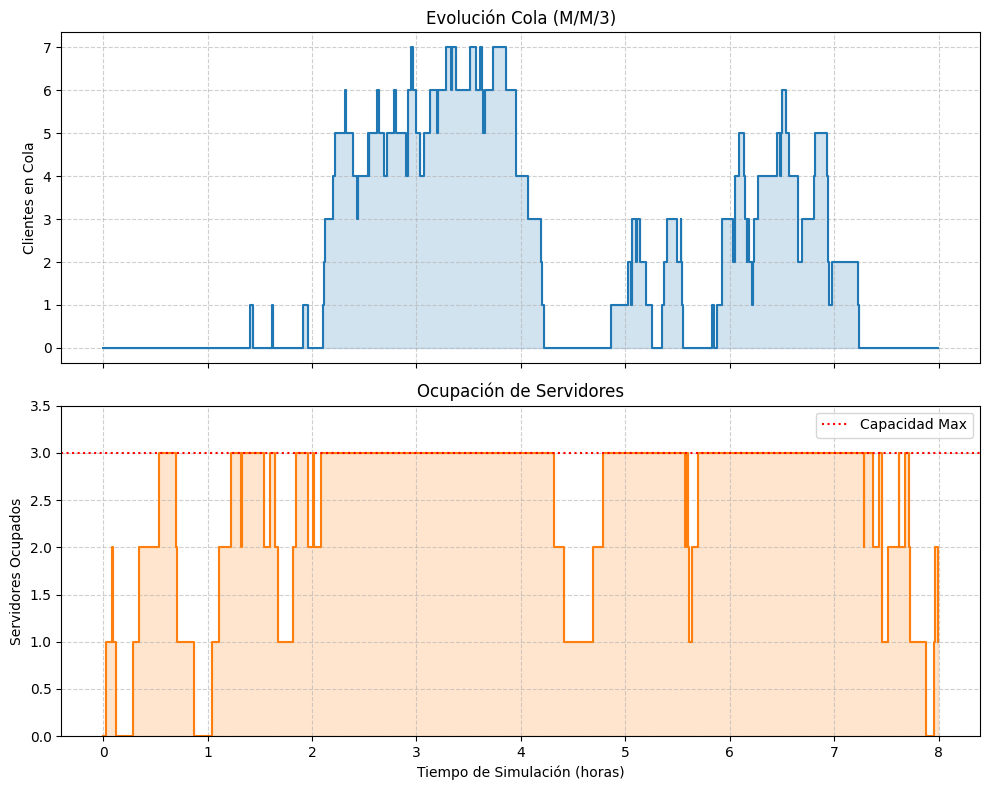

In [15]:
# Generar el gráfico de pasos
mi_simulacion.graficar_historial()

### Parte 4 - Modelos Continuos

Para implementar un modelo de simulación de eventos basado en un **Proceso de Poisson No Homogéneo (NHPP)** mediante el **método de Thinning** (o adelgazamiento de Lewis-Shedler), el primer paso consiste en definir una tasa mayorante constante $\lambda^*$, la cual debe ser igual o superior al valor máximo que alcanza la función de intensidad variable $\lambda(t)$ durante todo el periodo de simulación. El motor de simulación avanza generando una secuencia de tiempos de arribo "candidatos" utilizando esta tasa máxima constante, creando efectivamente un proceso de Poisson homogéneo que "sobremuestrea" la línea de tiempo con más eventos de los necesarios.

El segundo paso es el proceso de filtrado estocástico que da nombre al método. Para cada evento candidato generado en el instante $t$, se evalúa si se conserva o se descarta mediante una prueba de aceptación-rechazo: se genera un número aleatorio uniforme $u \in [0, 1]$ y se compara con el ratio $\lambda(t) / \lambda^*$. Si $u$ es menor o igual a esta proporción, el evento se acepta y se procesa; de lo contrario, se ignora (se "adelgaza" la secuencia). De esta forma, la probabilidad de aceptar un evento es proporcional a la intensidad real en ese momento, resultando en una distribución de eventos que se ajusta fielmente a la curva de la tasa variable $\lambda(t)$.

#### Implementación de NHPPP por Thinning

Así para esta simulación se diseña una función de intensidad $\lambda(t)$ que es realista para una simulación de 7 días: simula ciclos diarios (como el tráfico de una web o clientes en una tienda) con picos durante el día y valles durante la noche. El algoritmo de Thinning (o Aceptación-Rechazo) funciona en tres pasos:

1. Dominancia: Se define una tasa constante $\lambda_{max}$ que sea mayor o igual a la tasa real $\lambda(t)$ en todo momento.
2. Generación: Se generan "candidatos" a eventos usando un Proceso de Poisson Homogéneo con la tasa máxima $\lambda_{max}$.
3. Filtrado (Thinning): Se acepta cada candidato como un evento real con probabilidad $P = \frac{\lambda(t)}{\lambda_{max}}$.

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Función de Intensidad
def intensity_function(t):
    """
    Define la tasa de llegada lambda(t).
    Ciclo diario (24h) con picos al mediodía.
    """
    cycle = 15 * np.sin(2 * np.pi * (t - 9) / 24)
    rate = 20 + cycle
    return max(0, rate)

# Función de Filtro
def simulate_nhpp_thinning(t_max, lambda_upper_bound):
    """
    Simulación NHPP mediante Thinning.
    Retorna: (lista de eventos, número total de intentos)
    """
    t = 0
    events = []
    candidates_count = 0
    
    while t < t_max:
        # 1. Generar candidato (Poisson Homogéneo)
        u1 = np.random.uniform(0, 1)
        w = -np.log(u1) / lambda_upper_bound
        t = t + w
        
        if t >= t_max:
            break
            
        candidates_count += 1
            
        # 2. Probabilidad de aceptación
        prob_acceptance = intensity_function(t) / lambda_upper_bound
        
        # 3. Test de aceptación (Thinning)
        u2 = np.random.uniform(0, 1)
        if u2 <= prob_acceptance:
            events.append(t)
            
    return np.array(events), candidates_count

# Generación de reporte de la simulación
def generar_reporte_texto(events, total_candidates, t_max, dias):
    """
    Imprime un resumen estadístico de la simulación en la consola.
    """
    num_events = len(events)
    # Calcular tiempos entre llegadas (Inter-arrival times)
    iat = np.diff(events)
    
    # Pre-cálculos para acortar las líneas de print
    eficiencia = num_events / total_candidates
    prom_global = num_events / t_max

    print("=" * 60)
    print(f" REPORTE DE SIMULACIÓN DE EVENTOS (NHPP) - {dias} DÍAS")
    print("=" * 60)
    
    print("\n--- MÉTRICAS GENERALES ---")
    print(f"Tiempo total simulado : {t_max} horas")
    print(f"Eventos generados     : {num_events}")
    print(f"Candidatos totales    : {total_candidates}")
    print(f"Eficiencia del Thinning: {eficiencia:.2%} "
          "(Eventos aceptados / Candidatos)")
    print(f"Promedio global        : {prom_global:.2f} eventos/hora")

    if len(iat) > 0:
        mean_iat = np.mean(iat)
        print("\n--- ESTADÍSTICAS DE TIEMPOS ENTRE LLEGADAS (IAT) ---")
        print(f"IAT Promedio          : {mean_iat:.4f} horas "
              f"({mean_iat * 60:.2f} minutos)")
        print(f"IAT Mínimo            : {np.min(iat):.6f} horas")
        print(f"IAT Máximo            : {np.max(iat):.4f} horas")
        print(f"Desviación Estándar   : {np.std(iat):.4f}")

    print("\n--- DESGLOSE DIARIO ---")
    # Dividimos el encabezado de la tabla para legibilidad
    header = f"{'Día':<10} | {'Rango Horario':<20} | " \
             f"{'Eventos':<10} | {'Promedio (ev/h)':<15}"
    print(header)
    print("-" * 65)
    
    for d in range(dias):
        start_t = d * 24
        end_t = (d + 1) * 24
        
        # Filtrar eventos que caen en este día (ruptura de línea lógica)
        day_events = events[
            (events >= start_t) & (events < end_t)
        ]
        
        count = len(day_events)
        avg = count / 24
        
        print(f"Día {d+1:<6} | {start_t:03d}h - {end_t:03d}h         | "
              f"{count:<10} | {avg:.2f}")
    
    print("=" * 60)

A continuación estas funciones se usan en una simulación de 7 días o 168 horas:

In [17]:
# Parámetros 
DIAS = 7
HORAS_TOTALES = DIAS * 24
LAMBDA_MAX = 35 

# Ejecución
events, candidates = simulate_nhpp_thinning(HORAS_TOTALES, LAMBDA_MAX)

# Generar Reporte de Texto 
generar_reporte_texto(events, candidates, HORAS_TOTALES, DIAS)

 REPORTE DE SIMULACIÓN DE EVENTOS (NHPP) - 7 DÍAS

--- MÉTRICAS GENERALES ---
Tiempo total simulado : 168 horas
Eventos generados     : 3294
Candidatos totales    : 5776
Eficiencia del Thinning: 57.03% (Eventos aceptados / Candidatos)
Promedio global        : 19.61 eventos/hora

--- ESTADÍSTICAS DE TIEMPOS ENTRE LLEGADAS (IAT) ---
IAT Promedio          : 0.0510 horas (3.06 minutos)
IAT Mínimo            : 0.000020 horas
IAT Máximo            : 1.1459 horas
Desviación Estándar   : 0.0724

--- DESGLOSE DIARIO ---
Día        | Rango Horario        | Eventos    | Promedio (ev/h)
-----------------------------------------------------------------
Día 1      | 000h - 024h         | 487        | 20.29
Día 2      | 024h - 048h         | 454        | 18.92
Día 3      | 048h - 072h         | 442        | 18.42
Día 4      | 072h - 096h         | 479        | 19.96
Día 5      | 096h - 120h         | 472        | 19.67
Día 6      | 120h - 144h         | 469        | 19.54
Día 7      | 144h - 168h    

Se visualizan los resultados de la simulación:

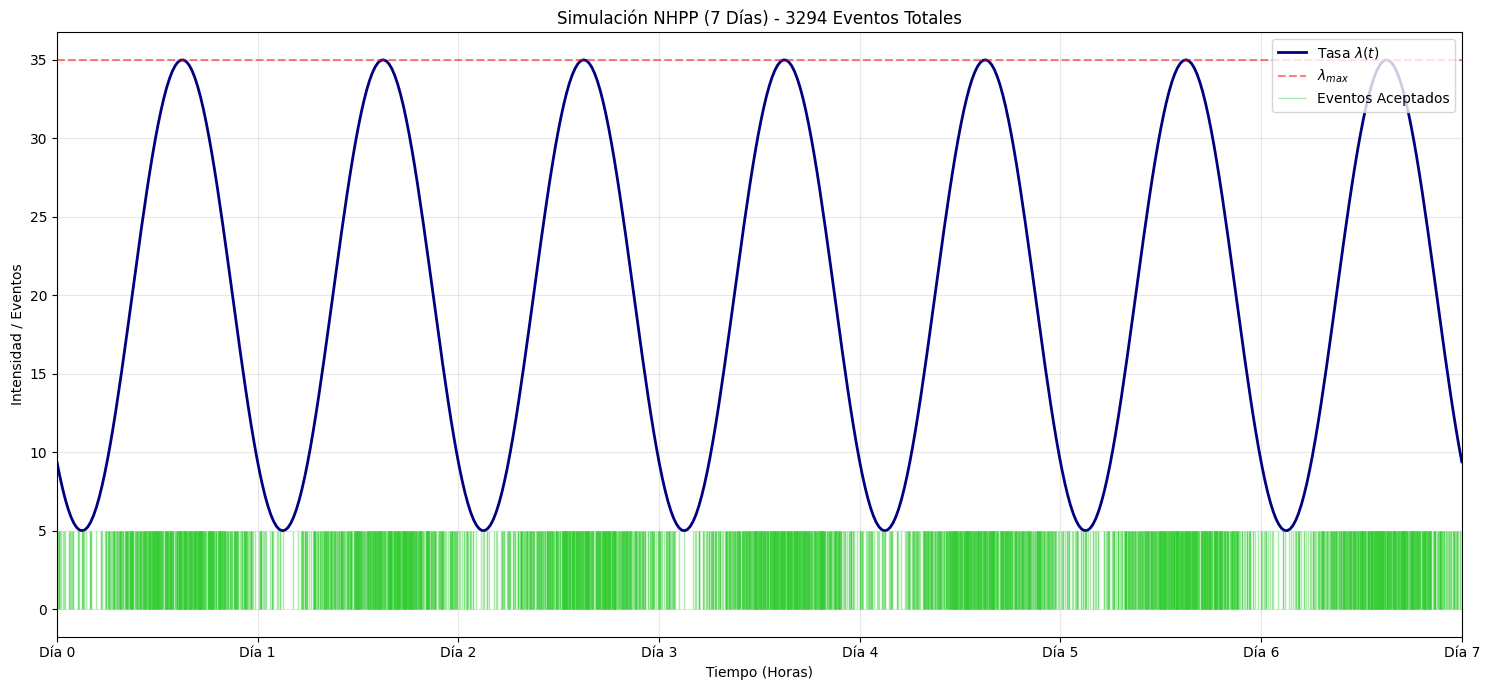

In [18]:
# Visualización
plt.figure(figsize=(15, 7))

t_values = np.linspace(0, HORAS_TOTALES, 500)
lambda_values = [intensity_function(t) for t in t_values]

# Gráfico de la tasa lambda (curva continua)
plt.plot(
    t_values, lambda_values, 
    color='navy', lw=2, label=r'Tasa $\lambda(t)$'
)

# Línea horizontal de Lambda Máximo
plt.hlines(
    LAMBDA_MAX, 0, HORAS_TOTALES, 
    colors='red', linestyles='--', alpha=0.5, 
    label=r'$\lambda_{max}$'
)

# Líneas verticales para cada evento aceptado
plt.vlines(
    x=events, ymin=0, ymax=5, 
    colors='limegreen', alpha=0.4, linewidth=1, 
    label='Eventos Aceptados'
)

plt.title(f'Simulación NHPP (7 Días) - {len(events)} Eventos Totales')
plt.xlabel('Tiempo (Horas)')
plt.ylabel('Intensidad / Eventos')
plt.xlim(0, HORAS_TOTALES)

# Configuración de los ticks del eje X
dias_ticks = np.arange(0, HORAS_TOTALES + 1, 24)
etiquetas_dias = [f'Día {i}' for i in range(len(dias_ticks))]
plt.xticks(dias_ticks, etiquetas_dias)

plt.grid(True, alpha=0.3)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

La visulización ilustra la evolución temporal de un Proceso de Poisson No Homogéneo (NHPP) durante un periodo de 168 horas, equivalente a siete días completos. El componente principal es la curva azul oscuro que representa la función de intensidad $\lambda(t)$, la cual exhibe un comportamiento perfectamente cíclico y sinusoidal, oscilando entre una tasa base cercana a 5 y un pico máximo de 35 eventos por hora. Sobre esta curva se proyecta una línea roja discontinua que marca la cota superior $\lambda_{max}$ (establecida en 35), la cual actúa como el techo de referencia necesario para la generación de eventos candidatos dentro del algoritmo de *Thinning*.

En la franja inferior, las líneas verticales verdes denotan los instantes exactos de los eventos finalmente aceptados por el modelo. Se observa una correlación directa entre la densidad de estas líneas y la magnitud de la función de intensidad: la concentración de eventos se vuelve densa y compacta coincidiendo con los picos de la onda sinusoidal, mientras que se dispersa notablemente durante los valles. Esta distribución visual confirma la eficacia del método de aceptación-rechazo, demostrando que la frecuencia de ocurrencia de los eventos se modula dinámicamente en función de la tasa variable $\lambda(t)$ en cada instante del tiempo.

### Parte 5 - Gillespie SSA o Next Reaction Method

Para implementar el **algoritmo de Gillespie (SSA) en este sistema**, primero se deben calcular en cada iteración las propensiones ($a_v$) que determinan la probabilidad instantánea de cada canal de reacción. Para la síntesis (orden cero), la propensión es constante, $a_1 = k_1 = 10$; para la degradación (primer orden), la propensión depende del estado actual de la población, $a_2 = k_2 \times [\text{mRNA}]$. Se calcula la propensión total $a_0 = a_1 + a_2$ y se genera el tiempo hasta el próximo evento ($\tau$) muestreando una distribución exponencial con media $1/a_0$ (usualmente $-\ln(u_1)/a_0$), lo que define cuánto tiempo transcurre en el sistema antes de que la configuración molecular cambie.

Una vez determinado el "cuándo", se decide el "qué" seleccionando una de las dos reacciones con probabilidad proporcional a su magnitud relativa ($P_{síntesis} = a_1/a_0$ y $P_{degradación} = a_2/a_0$). Dependiendo de la reacción elegida, se actualiza el contador de moléculas de mRNA incrementándolo o decrementándolo en una unidad, se avanza el tiempo de simulación ($t \leftarrow t + \tau$) y, crucialmente, se recalculan las propensiones para el siguiente paso, dado que $a_2$ cambiará cada vez que varíe la cantidad de mRNA, capturando así las fluctuaciones estocásticas intrínsecas del sistema.

#### Algoritmo de Gillespie (Método Directo)

Esta es una implementación del Algoritmo de Gillespie (Método Directo) en Python para el sistema de nacimiento y muerte (producción y degradación de ARNm) planteado:

$$\to \text{mRNA} (k_{1}=10)$$
$$\text{mRNA}\to (k_{2}=1)$$

Basado en esta descripción tenemos dos reacciones:
1. Producción (Transcripción): $\emptyset \xrightarrow{k_1} \text{mRNA}$. Tasa constante: $k_1 = 10$. Esta reacción incrementa el conteo de ARNm en 1.
3. Degradación: $\text{mRNA} \xrightarrow{k_2} \emptyset$. Tasa dependiente de la cantidad actual: $k_2 = 1$. Esta reacción disminuye el conteo de ARNm en 1.

Cabe destacar que el estado estacionario promedio esperado es $k_1 / k_2 = 10$ moléculas. El estado estacionario promedio de $10$ moléculas se fundamenta en el principio de equilibrio dinámico, el cual se alcanza cuando la velocidad de entrada (producción) iguala a la velocidad de salida (degradación) del sistema. Dado que la producción ocurre a una tasa constante $k_1$ y la degradación es proporcional a la cantidad de moléculas presentes ($k_2 \cdot \text{mRNA}$), el balance se logra matemáticamente cuando $k_1 = k_2 \cdot \text{mRNA}$; al despejar la concentración de equilibrio, se obtiene el cociente $k_1 / k_2$, lo que resulta en un valor promedio de $10$ moléculas para los parámetros dados.

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Funcion de Simulacion
def gillespie_ssa(k1, k2, t_max):
    # Inicialización
    t = 0.0
    # Condición inicial (puedes cambiarla)
    mRNA = 0
    
    # Listas para guardar el historial (para graficar)
    time_points = [t]
    mRNA_counts = [mRNA]
    
    while t < t_max:
        # 1. Calcular las propensiones (propensities)
        # a1: Probabilidad de producción (constante)
        a1 = k1
        # a2: Prob. degradación (proporcional a moléculas)
        a2 = k2 * mRNA
        
        a_sum = a1 + a2
        
        # Si a_sum es 0, el sistema para (sin reacciones)
        if a_sum == 0:
            break
            
        # 2. Determinar tiempo hasta próxima reacción (tau)
        # Se extrae de una distribución exponencial
        r1 = np.random.rand()
        tau = (1.0 / a_sum) * np.log(1.0 / r1)
        
        # 3. Determinar qué reacción ocurre
        r2 = np.random.rand()
        
        if r2 < (a1 / a_sum):
            # Ocurre Reacción 1: Producción
            mRNA += 1
        else:
            # Ocurre Reacción 2: Degradación
            mRNA -= 1
            
        # 4. Actualizar tiempo y guardar estado
        t += tau
        time_points.append(t)
        mRNA_counts.append(mRNA)
        
    return time_points, mRNA_counts

# Función para Generar el Informe
def generar_informe_texto(tiempos, conteos, k1, k2):
    # Convertir a numpy array para cálculos estadísticos
    arr_conteos = np.array(conteos)
    
    # Cálculos estadísticos sobre la simulación
    media_sim = np.mean(arr_conteos)
    desv_std = np.std(arr_conteos)
    var_sim = np.var(arr_conteos)
    min_val = np.min(arr_conteos)
    max_val = np.max(arr_conteos)
    
    total_ev = len(tiempos) - 1
    t_final = tiempos[-1]
    
    # Valores Teóricos
    media_teorica = k1 / k2
    # En Poisson ideal, varianza es igual a la media
    var_teorica = media_teorica 
    
    # Cálculo del error relativo (dividido en pasos)
    diff = abs(media_sim - media_teorica)
    error_rel = (diff / media_teorica) * 100

    # Definimos separadores para usar dentro del f-string
    sep = "=" * 50
    sub = "-" * 50

    # Construcción del reporte usando concatenación implícita
    # para respetar el ancho de 70 caracteres en el editor
    informe = (
        f"\n{sep}\n"
        f"SIMULACIÓN ESTOCÁSTICA (GILLESPIE SSA)\n"
        f"{sep}\n\n"
        f"1. PARÁMETROS DEL SISTEMA\n"
        f"{sub}\n"
        f"Reacción 1 (Producción) k1 : {k1}\n"
        f"Reacción 2 (Degradación) k2: {k2}\n"
        f"Tiempo total simulado      : {t_final:.2f} u.t.\n"
        f"Total de eventos ocurridos : {total_ev}\n\n"
        f"2. ANÁLISIS ESTADÍSTICO DE LA TRAYECTORIA\n"
        f"{sub}\n"
        f"Media observada            : {media_sim:.4f} mols\n"
        f"Desviación estándar        : {desv_std:.4f}\n"
        f"Varianza observada         : {var_sim:.4f}\n"
        f"Rango de fluctuación       : [{min_val}] - [{max_val}]\n\n"
        f"3. VALIDACIÓN CON MODELO TEÓRICO\n"
        f"{sub}\n"
        f"Estado Estacionario Esp.   : {media_teorica:.4f} mols\n"
        f"Varianza Esperada (Poisson): {var_teorica:.4f}\n"
        f"Error Relativo (Media)     : {error_rel:.2f}%\n"
    )
    
    return informe

A continuación se usa la simulación para el sistema planteado:

In [20]:
# Parámetros
# Dado que se simulan ARNm, los procesos de transcripción y 
# degradación suelen medirse en minutos o horas.
k1 = 10.0
k2 = 1.0
t_max = 1000.0 

# Simular
tiempos, conteos = gillespie_ssa(k1, k2, t_max)

# Generar e imprimir informe
reporte = generar_informe_texto(tiempos, conteos, k1, k2)
print(reporte)


SIMULACIÓN ESTOCÁSTICA (GILLESPIE SSA)

1. PARÁMETROS DEL SISTEMA
--------------------------------------------------
Reacción 1 (Producción) k1 : 10.0
Reacción 2 (Degradación) k2: 1.0
Tiempo total simulado      : 1000.00 u.t.
Total de eventos ocurridos : 20185

2. ANÁLISIS ESTADÍSTICO DE LA TRAYECTORIA
--------------------------------------------------
Media observada            : 10.7573 mols
Desviación estándar        : 3.3082
Varianza observada         : 10.9444
Rango de fluctuación       : [0] - [24]

3. VALIDACIÓN CON MODELO TEÓRICO
--------------------------------------------------
Estado Estacionario Esp.   : 10.0000 mols
Varianza Esperada (Poisson): 10.0000
Error Relativo (Media)     : 7.57%



Se visualizan los resultados de la simulación:

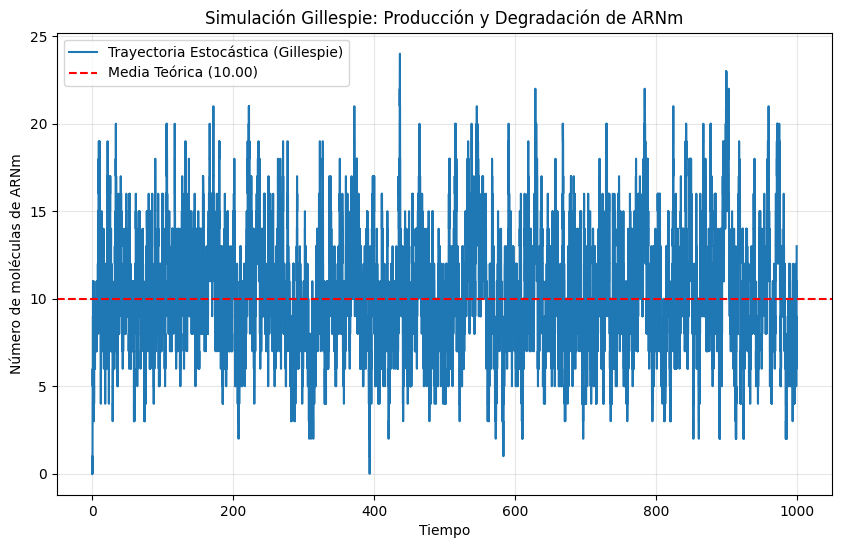

In [21]:
# Visualización
plt.figure(figsize=(10, 6))

# Graficar trayectoria (step plot para saltos discretos)
plt.step(
    tiempos,
    conteos,
    where='post',
    label='Trayectoria Estocástica (Gillespie)'
)

# Graficar la media teórica (k1 / k2)
media_teorica = k1 / k2

plt.axhline(
    y=media_teorica,
    color='r',
    linestyle='--',
    # Usamos .2f para evitar que el número sea muy largo
    label=f'Media Teórica ({media_teorica:.2f})'
)

plt.title(
    'Simulación Gillespie: Producción y Degradación de ARNm'
)
plt.xlabel('Tiempo')
plt.ylabel('Número de moléculas de ARNm')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

La visualización ilustra la naturaleza estocástica del sistema de producción y degradación de ARNm, donde la trayectoria azul exhibe fluctuaciones continuas y aleatorias inherentes al ruido intrínseco del proceso biológico. Se observa que, tras superar la condición inicial nula, el número de moléculas oscila dinámicamente alrededor del valor de equilibrio teórico señalado por la línea discontinua roja (10 moléculas), demostrando que, si bien el promedio temporal del sistema converge al modelo determinista, el estado instantáneo varía constantemente dentro de un rango de dispersión característico (aproximadamente entre 0 y 23 moléculas).

### Parte Integradora - Simulación de Tráfico Aéreo

Se propone un modelo de simulación híbrida de tráfico aéreo donde el flujo de entrada de aeronaves se gestiona mediante un Proceso de Poisson No Homogéneo (NHPP) utilizando el método de Thinning. Este componente permite modelar fielmente las curvas de demanda operativa del aeropuerto, generando llegadas estocásticas que respetan los picos horarios (horas punta) y los valles nocturnos. Estas entidades (aviones) ingresan a un sistema de colas modelado bajo la lógica M/M/1, donde la pista de aterrizaje actúa como el servidor único con tiempos de servicio exponenciales, gestionando tanto la cola de espera en el aire (holding pattern) como en tierra (taxiway).

De forma paralela y asíncrona, se ejecuta un motor basado en el Algoritmo de Gillespie (SSA) para simular la dinámica meteorológica. En este contexto, los estados del clima (ej. "Despejado", "Viento Cruzado", "Tormenta Eléctrica") se tratan como "especies químicas" discretas que transicionan estocásticamente en función de tasas de cambio históricas (propensidades). El algoritmo de Gillespie determina los intervalos exactos de tiempo en los que el sistema permanece en cada estado climático, generando una línea de tiempo de condiciones ambientales independiente del tráfico aéreo pero estadísticamente exacta.

La integración de ambos modelos se realiza mediante una modulación dinámica de la tasa de servicio ($\mu$). El estado vigente dictado por el módulo Gillespie actúa como una variable de control sobre el modelo M/M/1: cuando Gillespie transiciona a un estado de "Tormenta", la tasa de servicio de la pista se reduce drásticamente o se anula ($\mu \to 0$), provocando que las operaciones de aterrizaje y despegue se aborten. Esto fuerza al sistema de colas a entrar en un régimen de saturación o desvío de entidades, permitiendo analizar no solo la congestión por volumen de tráfico, sino la resiliencia del aeropuerto ante ventanas de inoperatividad estocástica y su capacidad de recuperación (recovery rate) una vez restablecidas las condiciones favorables.

El pipeline de ejecución se orquesta mediante un reloj maestro que sincroniza dos generadores de eventos concurrentes: un módulo de tráfico que inyecta entidades (aeronaves) en la línea de tiempo usando NHPP por Thinning para replicar la demanda horaria, y un motor Gillespie independiente que actualiza asincrónicamente el estado global del clima (variables de entorno). Dentro del bucle principal de procesamiento (LEF), la lógica del servidor M/M/1 consulta en tiempo real el estado vigente dictado por Gillespie antes de intentar atender a una aeronave; si el motor climático indica un evento adverso (ej. "Tormenta"), se activa una interrupción que anula o penaliza drásticamente la tasa de servicio ($\mu$), forzando la acumulación de entidades en la cola hasta que una nueva transición estocástica del clima restablezca la operatividad, permitiendo así medir el impacto sistémico de la interrupción.

Iniciando Simulación Híbrida (24.0h)

REPORTE DE SIMULACIÓN AEROPORTUARIA HÍBRIDA
Duración Simulación     : 24.0 horas
Total Llegadas (NHPP)   : 304
Aterrizajes Exitosos    : 303
Operaciones Abortadas   : 1 (Go-arounds)
--------------------------------------------------
METEOROLOGÍA (GILLESPIE SSA)
Eventos de Cambio Clima : 6
Tiempo en Tormenta      : 2.84 h (11.8%)



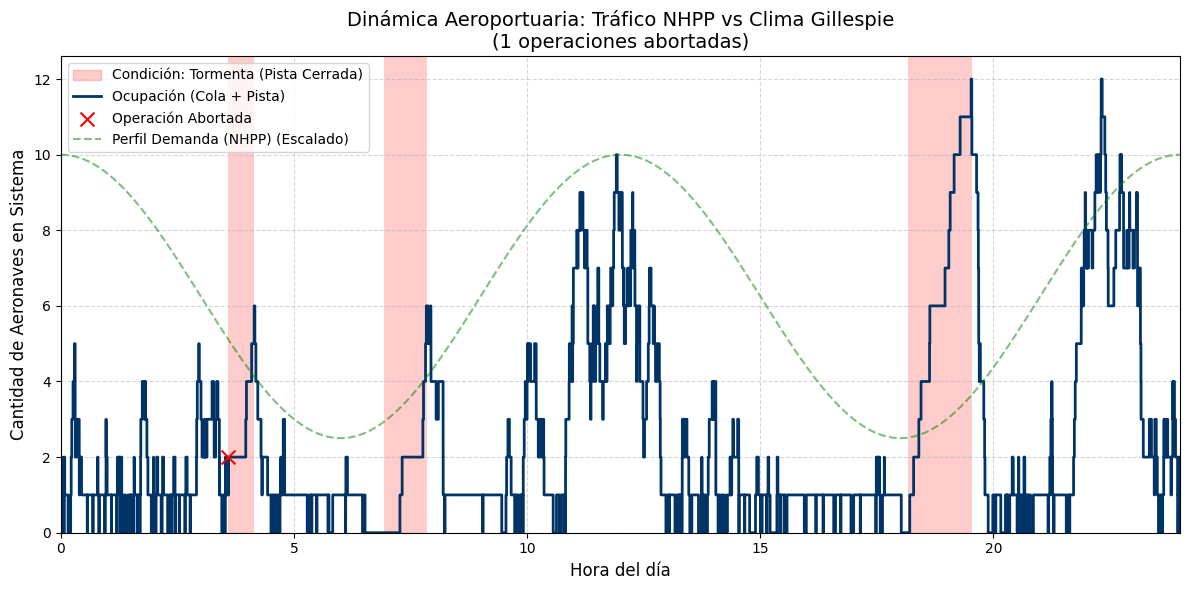

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import heapq
import random

# ==========================================
# 1. CONFIGURACIÓN Y PARÁMETROS
# ==========================================
SIM_DURATION = 24.0  # Horas
SEED = rnd_seed

# Parámetros de Tráfico (NHPP)
LAMBDA_MAX = 20.0    # Tasa máxima de llegadas (aviones/hora) para Thinning
MU_OPERATIVO = 25.0  # Tasa de servicio de la pista (aviones/hora) en buen clima

# Parámetros Climáticos (Gillespie)
# Estado 0: Despejado, Estado 1: Tormenta
TASA_DESPEJADO_A_TORMENTA = 0.15  # Frecuencia de aparición de tormentas
TASA_TORMENTA_A_DESPEJADO = 0.8   # Velocidad de recuperación (duración tormenta)

# Tipos de Eventos
EVT_ARRIVAL = 0
EVT_DEPARTURE = 1
EVT_WEATHER = 2

# Estados del Clima
CLIMA_CLEAR = 0
CLIMA_STORM = 1

np.random.seed(SEED)
random.seed(SEED)

class HybridAirportSim:
    def __init__(self, t_max):
        self.t_max = t_max
        self.clock = 0.0
        
        # Estado del Sistema
        self.queue_count = 0        # Aviones en cola (aire + tierra)
        self.server_busy = False    # Estado de la pista
        self.weather_state = CLIMA_CLEAR
        
        # Gestión de Eventos (Lista de Eventos Futuros - LEF)
        self.events = []  # Heapq
        
        # Control de Eventos de Salida (para poder cancelarlos)
        self.current_departure_token = None 
        
        # Estadísticas
        self.stats = {
            'arrivals': 0,
            'completed': 0,
            'aborted_ops': 0,  # Operaciones canceladas por clima
            'weather_changes': 0,
            'storm_duration': 0.0
        }
        
        # Historiales para graficar (tiempo, valor)
        self.history_occupancy = [(0.0, 0)]
        self.history_weather = [(0.0, CLIMA_CLEAR)]
        self.history_aborts = [] # Puntos (t, y) donde hubo abortos
        
    def schedule_event(self, time, event_type, token=None):
        if time <= self.t_max:
            heapq.heappush(self.events, (time, event_type, token))

    # ---------------------------------------------------------
    # MÓDULO 1: TRÁFICO AÉREO (NHPP - Thinning Algorithm)
    # ---------------------------------------------------------
    def get_arrival_rate(self, t):
        """
        Función de intensidad lambda(t).
        Modela picos de tráfico a las 8am y 6pm.
        """
        # Base de 5 aviones + oscilación de hasta 10 aviones
        # t está en horas (0-24)
        cycle = np.sin((t - 6) * np.pi / 12) ** 2  
        rate = 5 + 15 * cycle 
        return rate

    def schedule_next_arrival_nhpp(self):
        """Genera la próxima llegada usando Thinning."""
        t_curr = self.clock
        while True:
            # 1. Generar paso de tiempo con tasa homogénea máxima
            u1 = random.random()
            dt = -np.log(u1) / LAMBDA_MAX
            t_curr += dt
            
            if t_curr > self.t_max:
                return # Fin de simulación
            
            # 2. Test de aceptación/rechazo (Thinning)
            lambda_t = self.get_arrival_rate(t_curr)
            prob_accept = lambda_t / LAMBDA_MAX
            
            if random.random() <= prob_accept:
                self.schedule_event(t_curr, EVT_ARRIVAL)
                break

    # ---------------------------------------------------------
    # MÓDULO 2: MOTOR CLIMÁTICO (GILLESPIE SSA)
    # ---------------------------------------------------------
    def schedule_next_weather_change(self):
        """
        Determina el tiempo hasta el próximo cambio de clima
        basado en propensiones estocásticas (Gillespie).
        """
        # Determinar propensión (a0) según estado actual
        if self.weather_state == CLIMA_CLEAR:
            a0 = TASA_DESPEJADO_A_TORMENTA
        else:
            a0 = TASA_TORMENTA_A_DESPEJADO
            
        # Tiempo hasta la próxima reacción (tau)
        if a0 > 0:
            r = random.random()
            tau = (1.0 / a0) * np.log(1.0 / r)
            next_time = self.clock + tau
            self.schedule_event(next_time, EVT_WEATHER)

    # ---------------------------------------------------------
    # MÓDULO 3: NÚCLEO DE SIMULACIÓN Y LÓGICA DE CONTROL
    # ---------------------------------------------------------
    def run(self):
        # Inicialización
        self.schedule_next_arrival_nhpp()
        self.schedule_next_weather_change()
        
        print(f"Iniciando Simulación Híbrida ({self.t_max}h)")
        
        while self.events:
            time, type, token = heapq.heappop(self.events)
            
            # Avanzar reloj
            self.clock = time
            
            # Registrar estado para gráficos (Step plot)
            curr_occupancy = self.queue_count + (1 if self.server_busy else 0)
            self.history_occupancy.append((self.clock, curr_occupancy))
            self.history_weather.append((self.clock, self.weather_state))
            
            # Despachador de eventos
            if type == EVT_ARRIVAL:
                self.handle_arrival()
            elif type == EVT_DEPARTURE:
                self.handle_departure(token)
            elif type == EVT_WEATHER:
                self.handle_weather_change()
                
        self.generate_report()
        self.plot_results()

    def handle_arrival(self):
        self.stats['arrivals'] += 1
        self.schedule_next_arrival_nhpp() # Programar siguiente recursivamente
        
        if not self.server_busy and self.weather_state == CLIMA_CLEAR:
            # Pista libre y buen clima: Aterrizaje inmediato
            self.server_busy = True
            self.schedule_departure()
        else:
            # Pista ocupada O clima adverso: A la cola (Holding)
            self.queue_count += 1

    def schedule_departure(self):
        # Generar tiempo de servicio exponencial
        service_time = random.expovariate(MU_OPERATIVO)
        
        # Crear un token único para este servicio
        # Esto permite invalidar el evento si el clima cambia
        token = random.randint(0, 1e9)
        self.current_departure_token = token
        
        self.schedule_event(self.clock + service_time, EVT_DEPARTURE, token)

    def handle_departure(self, token):
        # Verificar si el token es válido (no fue abortado)
        if token != self.current_departure_token:
            return # Evento ignorado (fue cancelado por clima)
            
        self.stats['completed'] += 1
        self.server_busy = False
        self.current_departure_token = None
        
        # Intentar procesar siguiente en cola SI el clima lo permite
        if self.queue_count > 0 and self.weather_state == CLIMA_CLEAR:
            self.queue_count -= 1
            self.server_busy = True
            self.schedule_departure()

    def handle_weather_change(self):
        self.stats['weather_changes'] += 1
        
        # Alternar estado (0 -> 1, 1 -> 0)
        self.weather_state = 1 - self.weather_state
        
        # LÓGICA DE INTERRUPCIÓN / RECUPERACIÓN
        if self.weather_state == CLIMA_STORM:
            # Transición a TORMENTA
            if self.server_busy:
                # ABORTAR OPERACIÓN
                # La aeronave debe hacer 'go-around' y volver a cola
                self.stats['aborted_ops'] += 1
                self.server_busy = False
                self.queue_count += 1 # Regresa a la cola
                
                # Invalida el evento de salida pendiente
                self.current_departure_token = None 
                
                # Guardar punto para gráfico
                self.history_aborts.append(
                    (self.clock, self.queue_count + 1)
                )
                
        elif self.weather_state == CLIMA_CLEAR:
            # Transición a DESPEJADO (Recuperación)
            # Si hay cola, reiniciar operaciones inmediatamente
            can_resume = (self.queue_count > 0 and 
                          not self.server_busy)
                          
            if can_resume:
                self.queue_count -= 1
                self.server_busy = True
                self.schedule_departure()

        # Programar siguiente cambio de clima (Gillespie)
        self.schedule_next_weather_change()

    # ---------------------------------------------------------
    # GENERACIÓN DE REPORTES Y GRÁFICOS
    # ---------------------------------------------------------
    def generate_report(self):
        # Calcular tiempo total en tormenta
        t_storm = 0
        # Alias para acortar líneas
        hist = self.history_weather
        
        for i in range(1, len(hist)):
            # Desglose de cálculo de tiempo
            t_curr = hist[i][0]
            t_prev = hist[i-1][0]
            t_delta = t_curr - t_prev
            
            state = hist[i-1][1]
            if state == CLIMA_STORM:
                t_storm += t_delta
        
        # Pre-cálculo de porcentaje para limpiar el f-string
        pct_storm = (t_storm / self.t_max) * 100

        print("\n" + "="*50)
        print("REPORTE DE SIMULACIÓN AEROPORTUARIA HÍBRIDA")
        print("="*50)
        
        print(f"Duración Simulación     : {self.t_max} horas")
        
        print(f"Total Llegadas (NHPP)   : "
              f"{self.stats['arrivals']}")
              
        print(f"Aterrizajes Exitosos    : "
              f"{self.stats['completed']}")
              
        print(f"Operaciones Abortadas   : "
              f"{self.stats['aborted_ops']} (Go-arounds)")
              
        print("-" * 50)
        print("METEOROLOGÍA (GILLESPIE SSA)")
        
        print(f"Eventos de Cambio Clima : "
              f"{self.stats['weather_changes']}")
              
        print(f"Tiempo en Tormenta      : {t_storm:.2f} h "
              f"({pct_storm:.1f}%)")
              
        print("="*50 + "\n")

    def plot_results(self):
        # Desempaquetar datos para historial de ocupación
        times = [x[0] for x in self.history_occupancy]
        occupancy = [x[1] for x in self.history_occupancy]
        
        # Procesar clima para rellenar áreas (fill_between)
        w_times = [x[0] for x in self.history_weather]
        w_states = [x[1] for x in self.history_weather]
        
        plt.figure(figsize=(12, 6))
        
        # 1. Dibujar Áreas de Tormenta
        for i in range(len(w_times)-1):
            t_start = w_times[i]
            t_end = w_times[i+1]
            state = w_states[i]
            
            if state == CLIMA_STORM:
                plt.axvspan(
                    t_start, t_end, 
                    color='red', alpha=0.2, lw=0
                )

        # Etiqueta fantasma para la leyenda del clima
        plt.axvspan(
            -1, -0.1, color='red', alpha=0.2, 
            label='Condición: Tormenta (Pista Cerrada)'
        )

        # 2. Curva de Ocupación
        plt.step(
            times, occupancy, where='post', 
            color='#003366', lw=2, 
            label='Ocupación (Cola + Pista)'
        )
        
        # 3. Marcar Abortos
        if self.history_aborts:
            ab_t = [x[0] for x in self.history_aborts]
            ab_y = [x[1] for x in self.history_aborts]
            plt.scatter(
                ab_t, ab_y, color='red', 
                marker='x', s=100, zorder=5, 
                label='Operación Abortada'
            )

        # 4. Curva de Demanda Teórica (Referencia)
        t_ref = np.linspace(0, self.t_max, 200)
        lambda_ref = [
            self.get_arrival_rate(t) for t in t_ref
        ]
        
        # Normalización visual
        mx_ref = max(lambda_ref) if lambda_ref else 0
        mx_occ = max(occupancy) if occupancy else 0
        
        scale_factor = 1
        if mx_ref > 0:
            scale_factor = mx_occ / mx_ref

        # Graficar perfil escalado
        plt.plot(
            t_ref, 
            np.array(lambda_ref) * 0.5, 
            '--', color='green', alpha=0.5, 
            label='Perfil Demanda (NHPP) (Escalado)'
        )

        # Construcción del título
        title_str = (
            f"Dinámica Aeroportuaria: Tráfico NHPP vs "
            f"Clima Gillespie\n"
            f"({self.stats['aborted_ops']} "
            f"operaciones abortadas)"
        )

        plt.title(title_str, fontsize=14)
        plt.xlabel('Hora del día', fontsize=12)
        plt.ylabel(
            'Cantidad de Aeronaves en Sistema', 
            fontsize=12
        )
        plt.legend(loc='upper left')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.xlim(0, self.t_max)
        plt.ylim(bottom=0)
        
        plt.tight_layout()
        plt.show()

# ==========================================
# EJECUCIÓN
# ==========================================
sim = HybridAirportSim(t_max=SIM_DURATION)
sim.run()

Analizando el gráfico generado por la simulación se puede destacar sobre estos resultados los siguientes puntos:

#### 1. Análisis de la Meteorología (Motor Gillespie)
El algoritmo estocástico generó tres eventos de tormenta (franjas rosas verticales) durante las 24 horas simuladas, demostrando la aleatoriedad del clima:
 * Madrugada (~03:30 - 04:30): Una tormenta breve en horas de baja demanda.
 * Mañana (~07:00 - 08:00): Una interrupción justo antes del primer pico de tráfico.
 * Tarde-Noche (~18:00 - 19:30): El evento más crítico del día.

#### 2. Interacción Crítica: El Efecto "Tormenta Perfecta"

El gráfico revela un comportamiento peculiar cerca de la hora 19:00.
 * Coincidencia Fatal: La tercera tormenta ocurre exactamente durante el pico máximo de demanda del perfil NHPP (línea verde punteada).
 * Saturación del Sistema: Al anularse la capacidad de servicio ($\mu = 0$) mientras la tasa de llegada ($\lambda$) estaba en su máximo, la ocupación (línea azul) se disparó verticalmente, alcanzando el máximo histórico del día (más de 12 aeronaves en sistema).
 * Conclusión Operativa: Esto demuestra la vulnerabilidad del aeropuerto: incluso con capacidad de sobra, una interrupción en hora de alta demanda genera colas exponenciales instantáneas.

#### 3. Operaciones Abortadas

Se observa una "X" roja al inicio de la primera tormenta (aprox. hora 03:30).
 * Interpretación: Justo cuando el motor Gillespie cambió el estado a "Tormenta", había una aeronave en proceso de aterrizaje (servidor ocupado). El sistema forzó un go-around, cancelando el servicio y devolviendo la aeronave a la cola, lo que se verifica visualmente con el incremento inmediato en la línea azul escalonada.
   
#### 4. Resiliencia y Recuperación

Observando las pendientes descendentes de la línea azul justo después de las franjas rojas (especialmente después de la hora 19:30):
 * El sistema muestra una alta tasa de recuperación. Una vez que el clima se despeja, la cola cae rápidamente de 12 a 2 aeronaves en cuestión de una hora.
 * Esto indica que la tasa de servicio nominal ($\mu = 25$) está bien dimensionada para absorber los retrasos acumulados, siempre y cuando las ventanas de tormenta no sean excesivamente largas.

Se puede concluir que la simulación validó la integración híbrida de dos de los algoritmos de simulación estudiados. El tráfico aéreo siguió el perfil de horas de alta demanda (NHPP), pero fue severamente distorsionado por las inyecciones de caos del motor climático (Gillespie), creando escenarios de congestión realista que un modelo estático no habría evidenciado.

### Uso de Inteligencia Artificial

En este trabajo se utilizó inteligencia artificial (Gemini) para:

- Transformar código base de R a Python
- Formatear gráficos
- Formatear código para que no ocupe más de 70 caracteres (restricción de renderizado de Quarto)
- Revisar estilo de la redacción

### Anexo: Código base en Python

In [23]:
# Código base
# Linear Congruential Generator (LGC)

def lcg(n, seed=123, a=1103515245, c=12345, m=2**31):
    x = seed
    seq = []
    for _ in range(n):
        x = (a * x + c) % m
        seq.append(x/m)
    return seq

alea = lcg(10)
for i in range(len(alea)):
    print(alea[i])

0.20531828328967094
0.6873863865621388
0.7767890496179461
0.4024707484059036
0.5324797946959734
0.10148253152146935
0.6351402262225747
0.34936570515856147
0.7226534709334373
0.027218241710215807


In [24]:
# Código base
# Estimación de Pi por Monte Carlo

import numpy as np

N = 100000
u1 = np.random.uniform(0, 1, N)
u2 = np.random.uniform(0, 1, N)
pi_est = 4 * np.mean(u1**2 + u2**2 <= 1)

print(f"Valor estimado de pi: {pi_est}")

Valor estimado de pi: 3.14836


In [25]:
# Código base
# Implementación Metropolis–Hastings

import numpy as np
from scipy.stats import binom

def mh(n_iter=5000, start=0.5, prop_sd=0.1):
    # Inicializar la cadena (array lleno de ceros)
    theta = np.zeros(n_iter)
    theta[0] = start
    
    # Bucle desde el segundo elemento (índice 1) hasta el final
    for t in range(1, n_iter):
        # Propuesta: Distribución normal centrada en el theta anterior
        # Equivalente en R: rnorm(1, theta[t-1], prop_sd)
        prop = np.random.normal(loc=theta[t-1], scale=prop_sd)
        
        # Verificación de límites (Prior Uniforme Implícito [0,1])
        # Si la propuesta se sale del rango [0, 1], se rechaza inmediatamente
        if prop < 0 or prop > 1:
            theta[t] = theta[t-1]
        else:
            # Calcular la Verosimilitud (Likelihood) usando la función 
            # de masa de probabilidad
            # Equivalente en R: dbinom(7, 10, prob)
            # * 1 representa el Prior (Uniforme)
            num = binom.pmf(k=7, n=10, p=prop) * 1      
            den = binom.pmf(k=7, n=10, p=theta[t-1]) * 1
            
            # Probabilidad de aceptación (alpha)
            ratio = num / den
            alpha = min(1, ratio)
            
            # Paso de Aceptación o Rechazo
            # Generamos un número aleatorio uniforme 
            # y lo comparamos con alpha
            if np.random.uniform() < alpha:
                # Aceptar la propuesta
                theta[t] = prop     
            else:
                # Rechazar y mantener el valor anterior
                theta[t] = theta[t-1] 
                
    return theta

chain = mh()
print(f"Media Posterior Estimada: {np.mean(chain):.4f}")

Media Posterior Estimada: 0.6778


In [26]:
# Codigo base 
# Simulación de Eventos Discretos (M/M/1 o M/M/c)

import numpy as np

def simulate_mm1(lam, mu, T_max):
    # Nota: 'lambda' es una palabra reservada en Python, usamos 'lam'
    t = 0.0
    n = 0
    
    # R usa la tasa (rate) para rexp: rexp(1, lambda)
    # Numpy usa la escala (scale = 1/rate): exponential(1/lam)
    t_arr = np.random.exponential(scale=1/lam)
    t_dep = float('inf')  # Infinito en Python
    
    arrivals = 0
    departures = 0
    wait_times = []  
    
    while t < T_max:
        if t_arr < t_dep:
            # --- Evento de Llegada ---
            t = t_arr
            n += 1
            arrivals += 1
            
            # Si el servidor estaba libre (n=1 tras la llegada)
            # se programa servicio
            if n == 1:
                t_dep = t + np.random.exponential(scale=1/mu)
            
            # Programar la siguiente llegada
            t_arr = t + np.random.exponential(scale=1/lam)
            
        else:
            # Evento de Salida
            t = t_dep
            n -= 1
            departures += 1
            # Se agrega el tiempo a la lista
            wait_times.append(t_dep) 
            
            if n > 0:
                # Si quedan clientes, programar la siguiente salida
                t_dep = t + np.random.exponential(scale=1/mu)
            else:
                # Si no hay nadie, la próxima salida es "infinita"
                t_dep = float('inf')
    
    # Se devuelve un diccionario con los tiempos
    return {
        "arrivals": arrivals, 
        "departures": departures, 
        "wait_times": wait_times
    }

# Lambda = 2 clientes/min, Mu = 3 clientes/min, Tiempo = 100 min
res = simulate_mm1(lam=2, mu=3, T_max=100)

print(f"Llegadas totales: {res['arrivals']}")
print(f"Salidas totales: {res['departures']}")
print("Últimos 5 tiempos de salida:")

for i in range(len(res['wait_times'])-5,len(res['wait_times'])):
    print(res['wait_times'][i])

Llegadas totales: 215
Salidas totales: 215
Últimos 5 tiempos de salida:
98.43347389754513
98.50944958825472
99.40263056754019
99.71489988562641
100.03483812961011


In [27]:
# Codigo base
# Implementación Gillespie SSA

import numpy as np
import pandas as pd

def gillespie(Tmax, k1=10, k2=1):
    t = 0.0
    X = 0
    
    # Listas para almacenar el historial
    ts = [t]
    xs = [X]
    
    while t < Tmax:
        # Cálculo de propensiones
        a1 = k1
        a2 = k2 * X
        a0 = a1 + a2
        
        # Si la propensión total es 0, el sistema se detiene
        if a0 == 0:
            break
            
        # 1. Generar tiempo hasta el próximo evento (tau)
        # R: -log(runif(1)) / a0 
        # Esto es matemáticamente generar una variable 
        # aleatoria Exponencial con tasa a0
        tau = np.random.exponential(scale=1/a0)
        
        # 2. Determinar qué evento ocurre
        r2 = np.random.uniform()
        
        if r2 * a0 < a1:
            # Evento 1: Nacimiento / Producción
            X += 1
        else:
            # Evento 2: Muerte / Degradación
            X = max(0, X - 1)
            
        # Actualizar tiempo y almacenar estado
        t += tau
        ts.append(t)
        xs.append(X)
        
    # Devolvemos un DataFrame de Pandas 
    return pd.DataFrame({'time': ts, 'X': xs})

df_result = gillespie(Tmax=50)

# Mostrar las primeras 5 filas
print(df_result.head())

       time  X
0  0.000000  0
1  0.031461  1
2  0.052792  2
3  0.214520  3
4  0.226669  4
